# Model a C3 diel leaf for 12hr photoperiod

## Install cobrapy

In [1]:
%pip install cobra --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 28.6 MB/s eta 0:00:00


## Import C3 model from Github

In [2]:
# Retrieving the model
!wget -q https://raw.githubusercontent.com/sshameer/DielLeafModeling/refs/heads/main/C3_model.sbml


## Import functions required to read sbml, write sbml and perform pFBA

In [3]:
from cobra.io import read_sbml_model
from cobra.io import write_sbml_model
from cobra.flux_analysis import pfba

## Import the model and constrain diel leaf model for C3 photosynthesis

In [4]:
C3_model = read_sbml_model("C3_model.sbml")

In [5]:
# constraining GPT transport reaction
C3_model.reactions.get_by_id("G6P_Pi_pc1").lower_bound= 0
C3_model.reactions.get_by_id("G6P_Pi_pc1").upper_bound= 0
C3_model.reactions.get_by_id("G6P_Pi_pc2").lower_bound= 0
C3_model.reactions.get_by_id("G6P_Pi_pc2").upper_bound= 0

In [6]:
# constraining sucrose accumulation to model a starch storing leaf
C3_model.reactions.get_by_id("SUCROSE_v_dielTransfer").bounds = (0,0)

In [7]:
# constraining starch phosphorylation
C3_model.reactions.get_by_id("RXN_1826_p1").lower_bound= 0
C3_model.reactions.get_by_id("RXN_1826_p1").upper_bound= 0
C3_model.reactions.get_by_id("RXN_1826_p2").lower_bound= 0
C3_model.reactions.get_by_id("RXN_1826_p2").upper_bound= 0

In [8]:
# Setting photon uptake
PPFD = 500 #umol/m2/s
C3_model.reactions.get_by_id("Photon_tx1").upper_bound = PPFD
C3_model.reactions.get_by_id("Photon_tx1").lower_bound = 0
# Setting maintenance cost
VATPase = 0.0049*PPFD+2.7851
C3_model.reactions.get_by_id("ATPase_tx1").bounds = (VATPase,VATPase)
C3sol = pfba(C3_model)

In [9]:
backup = C3_model.copy()

This simple C3 model set up represents a 12-12 hour day. In order to model days of different daylength when the fluxes are all represented in umol/m2/s, the stoichiometry of all linker reactions need to be updated to reflect the difference in daylength such that the stoichiometry on the day metabolite is (24-daylength)/daylength

In [62]:
C3_model = backup.copy()

daylength = 16

for rxn in C3_model.reactions.query("_dielTransfer"):
  # print(rxn.id)
  # print(rxn.reaction)
  for met in rxn.reactants:
    stoich = rxn.metabolites[met]
    rxn.add_metabolites({met:round((-1*stoich)+(stoich*(24-daylength)/daylength),3)})
  # print(rxn.reaction)



Confirm that the change in stoichiometry has been successful

In [63]:
print("Original stoichiometry:")
print(backup.reactions.get_by_id("STARCH_p_dielTransfer").reaction)

print("\nNew stoichiometry:")
print(C3_model.reactions.get_by_id("STARCH_p_dielTransfer").reaction)

Original stoichiometry:
STARCH_p1 <=> STARCH_p2

New stoichiometry:
0.5 STARCH_p1 <=> STARCH_p2


In [64]:
C3sol = pfba(C3_model)

In [65]:
# Starch synthesis reaction is identified
StarchSynDay = C3_model.reactions.get_by_id("GLYCOGENSYN_RXN_p1")
# Number of moles of starch (GLC units) generated by the reaction is noted
StarchDayStoich = C3_model.reactions.get_by_id("GLYCOGENSYN_RXN_p1").metabolites[C3_model.metabolites.get_by_id("STARCH_p1")]
# Print starch synthesis rate
print("Starch synthesis rate (umol GLC/m2/s) ="+str(StarchSynDay.flux*StarchDayStoich))
print("Total starch accumulated over "+str(daylength)+"hr photperiod (mmol GLC/m2) ="+str(StarchSynDay.flux*StarchDayStoich*daylength*3600/1000))
print("")

# Starch degradation reaction is identified
StarchDegNight = C3_model.reactions.get_by_id("RXN_1827_p2")
# Number of moles of starch (GLC units) generated by the reaction is noted
StarchNightStoich = C3_model.reactions.get_by_id("RXN_1827_p2").metabolites[C3_model.metabolites.get_by_id("STARCH_p2")]
# Print starch degradation rate (flux is converted to absolute values)
print("Starch degradation rate by hydrolysis (umol GLC/m2/s) ="+str(abs(StarchDegNight.flux*StarchNightStoich)))
print("Total starch degraded over "+str(24-daylength)+"hr photperiod (mmol GLC/m2) ="+str(abs(StarchDegNight.flux*StarchNightStoich)*(24-daylength)*3600/1000))

Starch synthesis rate (umol GLC/m2/s) =0.9852014076347134
Total starch accumulated over 16hr photperiod (mmol GLC/m2) =56.74760107975949

Starch degradation rate by hydrolysis (umol GLC/m2/s) =1.9704028152694268
Total starch degraded over 8hr photperiod (mmol GLC/m2) =56.74760107975949


# Studying relationship between daylength and transitory starch accumulated

In order to repeat the process of setting daylenght and calculating total starch accumulated multiple times, the above lines of code can be packed in a function

In [66]:
def calculateTransitoryStarchLevels(Orig_model,daylength):
  new_model = Orig_model.copy()

  #update stoichiometry based on daylength
  for rxn in new_model.reactions.query("_dielTransfer"):
    for met in rxn.reactants:
      stoich = rxn.metabolites[met]
      rxn.add_metabolites({met:round((-1*stoich)+(stoich*(24-daylength)/daylength),3)})

  # perform pFBA
  tempsol = pfba(new_model)

  # Starch synthesis reaction is identified
  StarchSynDay = new_model.reactions.get_by_id("GLYCOGENSYN_RXN_p1")
  # Number of moles of starch (GLC units) generated by the reaction is noted
  StarchDayStoich = new_model.reactions.get_by_id("GLYCOGENSYN_RXN_p1").metabolites[new_model.metabolites.get_by_id("STARCH_p1")]
  # Starch accumulation rate
  Answer = StarchSynDay.flux*StarchDayStoich
  return(Answer)


In [70]:
# create variables to store the daylengths, starch accumulation rate and total starch accumulated
daylengthList = [6,8,12,16,18]
StarchAccumRateList = []

# Using a for loop simulate daylength of 6hrs, 8hrs, 12hrs, 16hrs and 18hrs
for daylength in daylengthList:
  StarchAccumRate = calculateTransitoryStarchLevels(backup,daylength)
  StarchAccumRateList.append(StarchAccumRate)
  print("Starch accumulation rate (mmol GLC/m2/s) ="+str(StarchAccumRate))

Total starch accumulation rate (mmol GLC/m2/s) =3.378587449729775
Total starch accumulated over 6hr photperiod (mmol GLC/m2) =72.97748891416315
Total starch accumulation rate (mmol GLC/m2/s) =2.711846636376434
Total starch accumulated over 8hr photperiod (mmol GLC/m2) =78.1011831276413
Total starch accumulation rate (mmol GLC/m2/s) =1.7000062660249575
Total starch accumulated over 12hr photperiod (mmol GLC/m2) =73.44027069227816
Total starch accumulation rate (mmol GLC/m2/s) =0.9852014076347134
Total starch accumulated over 16hr photperiod (mmol GLC/m2) =56.74760107975949
Total starch accumulation rate (mmol GLC/m2/s) =0.7614706924714428
Total starch accumulated over 18hr photperiod (mmol GLC/m2) =49.3433008721495


## Plotting the results

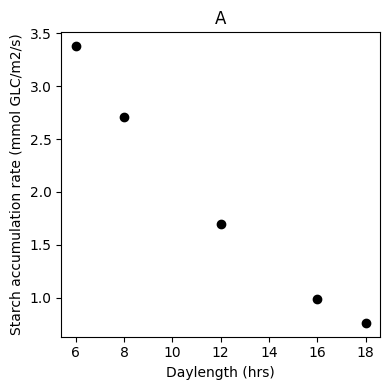

In [85]:
from matplotlib import pyplot as plt

# Create two subplots side by side
fig, axs = plt.subplots(1, 1, figsize=(4, 4))  # 1 row, 2 columns

# Plot starch accumulation rate vs daylength
axs.scatter(daylengthList, StarchAccumRateList,color="black")
axs.set_xlabel("Daylength (hrs)")
axs.set_ylabel("Starch accumulation rate (mmol GLC/m2/s)")
axs.set_title("A")

plt.tight_layout()
plt.show()

From plotting, we see that starch accumulation rate is inversely related to daylength. This is in-line with known leaf behaviour [Hewitt et. al., 1985](https://academic.oup.com/aob/article/56/4/513/251815)